# Evaluation of dataset encoding methods

The goal of this notebook is to explore how preprocessing options (applying different transformation and encoding approaches and their combinations) impact visualization using t-SNE and PCA technique.  
We will use:  
- Weight-of-Evidence approach to encode values ([medium.com](https://medium.com/mlearning-ai/weight-of-evidence-woe-and-information-value-iv-how-to-use-it-in-eda-and-model-building-3b3b98efe0e8), [analyticsvidhya.com](https://www.analyticsvidhya.com/blog/2021/06/understand-weight-of-evidence-and-information-value/))
- features binning  
- imputing values to one feature using corresponding values from another
- cutoff values for features with long tail in distribution  
- simple ordinal encoding for features such as "day of week"  
- one-hot encoding

Tasks:  
- create custom data preprocessing classes which can be used in pipelines
- get hands-on experience in constructing pipelines to prepare data for training and evaluating models
- test the Weight-of-Evidence encoding technique

In [1]:
from datetime import datetime, timedelta

import numpy as np
print('Numpy version:', np.__version__)

import pandas as pd
print('Pandas version:', pd.__version__)

import matplotlib as mpl
print('Matplotlib version:', mpl.__version__)
import matplotlib.pyplot as plt

import seaborn as sns
print('Seaborn version:', sns.__version__)

import sklearn as skl
print('Scikit-learn version:', skl.__version__)
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, confusion_matrix, roc_curve, precision_recall_fscore_support,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)

import warnings
warnings.filterwarnings('ignore')

Numpy version: 1.23.5
Pandas version: 1.5.2
Matplotlib version: 3.6.2
Seaborn version: 0.12.1
Scikit-learn version: 1.1.3


In [2]:
# importing created custom classes for dataset transformation using pipeline
from pipeline_preprocess import (
    DFDropColumns, DFWoeEncoder, DFColumnBinning, DFValuesMapper, DFFuncApplyCols,
    DFCrossFeaturesImputer, DFOneHotEncoder, DFOrdinalEncoder, DFValuesReplacer
)

In [3]:
import logging
import sys

logger = logging.getLogger('nb') # create handler only, from classes use getLogger(<name>)
logger.setLevel(logging.DEBUG)

handler = logging.StreamHandler(stream=sys.stdout)
handler.setFormatter(logging.Formatter(fmt='[%(asctime)s: %(name)s.%(funcName)s: %(levelname)s] %(message)s'))
logger.addHandler(handler)

## Utility functions

In [4]:
# calculating real missing data ratio considering missing-like values (nan-equivalents)
def print_real_nans_ratio(df, cat_nan_equiv='unknown', num_nan_equiv=999):
    print(f'Calculating real NaNs ratio using `{str(cat_nan_equiv)}` and `{str(num_nan_equiv)}` keyvalues:')
    print('Column (value) \tNvalues \tRatio')
    print('-'*40)
    for col in df.columns:
        if df[col].dtype == 'object':
            nan_equiv = cat_nan_equiv
        else:
            nan_equiv = num_nan_equiv
        if nan_equiv in list(df[col]):
            freq_table = df[col].value_counts()
            print('{} (`{}`) \t{} \t{:.1f}%'.format(col, nan_equiv, freq_table[nan_equiv], 100 * freq_table[nan_equiv] / len(df)))

In [5]:
# loading and preprocessing data using pipeline specified
def preprocess_data(df=None, filename=None, y=None, target='y', pipeline=None, fit=False):
    """
    1. Loads data from file (if DataFrame is not loaded earlier)
    2. Splits DataFrame to target and predictors (if y not passed directly)
    3. Preprocess data using pipeline with ability to toggle fit stage
    """
    if df is None:
        if filename is None:
            raise ValueError('No filename passed')
        df_mod = pd.read_csv(filename)
    else:
        df_mod = df.copy()
    if (y is None) and (target in df_mod.columns):
        y_mod = pd.to_numeric(df_mod[target].map({'yes': 1, 'no': 0}))
        df_mod = df_mod.drop(columns=target)
    else:
        y_mod = y.copy()
    if pipeline is not None:
        if fit:
            df_mod = pipeline.fit_transform(df_mod, y_mod)
        else:
            df_mod = pipeline.transform(df_mod)
    return (df_mod, y_mod)

In [6]:
def get_model_results(model, train_set, test_set=None, show_charts=False):
    """
    Calculates, returns and displays if necessary binary classification model results
    based on train and test sets
    """
    metrics = {'accuracy': accuracy_score, 'precision': precision_score, 'recall': recall_score, 'f1': f1_score, 'auc': roc_auc_score}
    if show_charts:
        if test_set is None:
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            conf_matrix_train = ConfusionMatrixDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0])
            roc_curve_train = RocCurveDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[1])
            pr_curve_train = PrecisionRecallDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[2])
        else:
            fig, axs = plt.subplots(2, 3, figsize=(15, 10))
            conf_matrix_train = ConfusionMatrixDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0, 0])
            roc_curve_train = RocCurveDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0, 1])
            pr_curve_train = PrecisionRecallDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0, 2])
            conf_matrix_test = ConfusionMatrixDisplay.from_estimator(estimator=model, X=test_set[0], y=test_set[1], ax=axs[1, 0])
            roc_curve_test = RocCurveDisplay.from_estimator(estimator=model, X=test_set[0], y=test_set[1], ax=axs[1, 1])
            pr_curve_test = PrecisionRecallDisplay.from_estimator(estimator=model, X=test_set[0], y=test_set[1], ax=axs[1, 2])
    
    results = {}
    print('Scores:')
    print('Indicator  \tTrain \tTest')
    print('='*40)
    for m_name, m_func in metrics.items():
        results[m_name] = {} 
        results[m_name]['train'] = m_func(train_set[1], model.predict(train_set[0]))
        if test_set is not None:
            results[m_name]['test'] = m_func(test_set[1], model.predict(test_set[0]))
        print('{}:     \t{:.4f} \t{:.4f}'.format(m_name, results[m_name]['train'], 0.0 if test_set is None else results[m_name]['test']))
    
    return results

## Loading train and test data

In [7]:
# defining missing-like values (determined at EDA stage)
cat_nan_equiv = 'unknown'
num_nan_equiv = 999

In [8]:
import_filename = 'datasets/bank-train.csv'
df = pd.read_csv(import_filename)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28831 entries, 0 to 28830
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             28831 non-null  int64  
 1   job             28831 non-null  object 
 2   marital         28831 non-null  object 
 3   education       28831 non-null  object 
 4   default         28831 non-null  object 
 5   housing         28831 non-null  object 
 6   loan            28831 non-null  object 
 7   contact         28831 non-null  object 
 8   month           28831 non-null  object 
 9   day_of_week     28831 non-null  object 
 10  duration        28831 non-null  int64  
 11  campaign        28831 non-null  int64  
 12  pdays           28831 non-null  int64  
 13  previous        28831 non-null  int64  
 14  poutcome        28831 non-null  object 
 15  emp.var.rate    28831 non-null  float64
 16  cons.price.idx  28831 non-null  float64
 17  cons.conf.idx   28831 non-null 

In [42]:
df['y'].value_counts()

0    25583
1     3248
Name: y, dtype: int64

In [9]:
print_real_nans_ratio(df, cat_nan_equiv, num_nan_equiv)

Calculating real NaNs ratio using `unknown` and `999` keyvalues:
Column (value) 	Nvalues 	Ratio
----------------------------------------
job (`unknown`) 	240 	0.8%
marital (`unknown`) 	58 	0.2%
education (`unknown`) 	1234 	4.3%
default (`unknown`) 	6051 	21.0%
housing (`unknown`) 	707 	2.5%
loan (`unknown`) 	707 	2.5%
duration (`999`) 	1 	0.0%
pdays (`999`) 	27734 	96.2%


In [10]:
# loading testset
df_test = pd.read_csv('datasets/bank-test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12357 entries, 0 to 12356
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             12357 non-null  int64  
 1   job             12357 non-null  object 
 2   marital         12357 non-null  object 
 3   education       12357 non-null  object 
 4   default         12357 non-null  object 
 5   housing         12357 non-null  object 
 6   loan            12357 non-null  object 
 7   contact         12357 non-null  object 
 8   month           12357 non-null  object 
 9   day_of_week     12357 non-null  object 
 10  duration        12357 non-null  int64  
 11  campaign        12357 non-null  int64  
 12  pdays           12357 non-null  int64  
 13  previous        12357 non-null  int64  
 14  poutcome        12357 non-null  object 
 15  emp.var.rate    12357 non-null  float64
 16  cons.price.idx  12357 non-null  float64
 17  cons.conf.idx   12357 non-null 

In [11]:
print_real_nans_ratio(df_test, cat_nan_equiv, num_nan_equiv)

Calculating real NaNs ratio using `unknown` and `999` keyvalues:
Column (value) 	Nvalues 	Ratio
----------------------------------------
job (`unknown`) 	90 	0.7%
marital (`unknown`) 	22 	0.2%
education (`unknown`) 	497 	4.0%
default (`unknown`) 	2546 	20.6%
housing (`unknown`) 	283 	2.3%
loan (`unknown`) 	283 	2.3%
duration (`999`) 	1 	0.0%
pdays (`999`) 	11939 	96.6%


## Construct preprocessing pipelines

In [12]:
# definition of inputs for binning and encoding
age_bins = pd.IntervalIndex.from_breaks(np.arange(15, 110, 10)) # will be used for cross-feature imputing
pdays_bins = pd.IntervalIndex.from_breaks([-1, 3, 6, 13, 50, 999], closed='right') # for exploration purposes
default_map = {'yes': 1, 'no': 0, 'unknown': 0} # values map using most frequent value
housing_map = {'yes': 1, 'no': 0, 'unknown': 1} # values map using most frequent value
loan_map = {'yes': 1, 'no': 0, 'unknown': 0} # values map using most frequent value
contact_map = {'cellular': 1, 'telephone': 0} # encoding map
month_map = {'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12} # encoding map
dow_map = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5} # encoding map
poutcome_map = {'nonexistent': 0, 'success': 1, 'failure': -1} # encoding map

# cutoff functions
cutoff_campaign = (lambda x: np.min([x, 6])) # value 6 was calculated at EDA stage for `campaign` feature as cutoff value
cutoff_previous = (lambda x: np.min([x, 3])) # value 3 was calculated at EDA stage for `previous` feature as cutoff value
cutoff_pdays = (lambda x: np.min([13, x])) # value 13 was calculated at EDA stage for `pdays` feature as cutoff value
binarize_pdays = (lambda x: int(x < 999)) # transforming to answer on question: was there a previous contact?

Here we are creating all the necessary pipelines.  
The first pipeline will use WoE mostly

In [13]:
# Preprocessing #1 - using WoE for all columns, cutoff numerical values
preproc_woe_allcols = [
    'WOE for all columns, no imputing, cutoff',
    Pipeline([
        ('binning', DFColumnBinning(bins_dict={'age': age_bins, 'pdays': pdays_bins}, new_names=['age_bins', 'pdays_bins'])),
        ('encode_woe_cat', DFWoeEncoder(
            columns=[
                'age_bins', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'pdays_bins'
            ], encode_nans=True, nan_equiv='unknown'
        )),
        ('cutoff', DFFuncApplyCols(map_func={
            'campaign': cutoff_campaign,
            'previous': cutoff_previous
        })),
        ('encode_woe_num', DFWoeEncoder(columns=['campaign', 'previous'], encode_nans=True, nan_equiv=999)),
        ('drop_cols', DFDropColumns(columns=['age', 'duration', 'pdays'])),
    ])
]

This pipeline is the same as the first one but we will also drop features with Information Value < 0.02 which is considered as threshold value for useless features (see 01-0_eda.ipynb)

In [14]:
# Preprocessing #2 - same as previous but drop columns with low Information Value
preproc_woe_allcols_droplowiv = [
    'WOE for all columns, no imputing, cutoff, drop low IV features',
    Pipeline([
        ('binning', DFColumnBinning(bins_dict={'age': age_bins, 'pdays': pdays_bins}, new_names=['age_bins', 'pdays_bins'])),
        ('encode_woe_cat', DFWoeEncoder(
            columns=[
                'age_bins', 'job', 'marital', 'education', 'default', 'contact', 'month', 'poutcome', 'pdays_bins'
            ], encode_nans=True, nan_equiv='unknown'
        )),
        ('cutoff', DFFuncApplyCols(map_func={
            'campaign': cutoff_campaign,
            'previous': cutoff_previous
        })),
        ('encode_woe_num', DFWoeEncoder(columns=['campaign', 'previous'], encode_nans=True, nan_equiv=999)),
        ('drop_cols', DFDropColumns(columns=['age', 'duration', 'pdays', 'day_of_week', 'housing', 'loan'])),
    ])
]

The next pipeline will use mix of WoE and ordinal encoding approaches. But before we will impute missing-like values in some features using corresponding values of the other features. To explain this let's use the `education` and `job` features.  
While performing EDA we noticed correlation between several pairs of categorical features (in fact it's more to association). `education` and `job` is one of these pairs. When we plotted 2-D histogram we were able to find "peaks" in frequencies. We can use these peaks to impute unknown values. For example if we have 'unknown' value in `education` feature for the observation but we know that the `job` == 'admin.' then we can assume that `education` == 'university.degree' as the most people who work as 'admin' have 'university.degree' in `education` field.  
We called this approach 'cross-feature imputing' and implemented corresponding class to use with pipelines.

In [15]:
# Preprocessing #3 - using simple encoding + partial WoE
preproc_enc_woe_part = [
    'encoding, WOE partial, imputing, cutoff',
    Pipeline([
        ('binning', DFColumnBinning(bins_dict={'age': age_bins}, new_names=['age_bins'])),
        ('cross-impute', DFCrossFeaturesImputer(cross_features={'education': 'job', 'job': 'education', 'marital': 'age_bins'}, nan_equiv=cat_nan_equiv)),
        ('replace_values', DFValuesReplacer(replaces={'default': {cat_nan_equiv: 'no'}, 'housing': {cat_nan_equiv: 'yes'}, 'loan': {cat_nan_equiv: 'no'}, 'pdays': {num_nan_equiv: -1}})),
        ('map_values', DFValuesMapper(map_values={'contact': contact_map})),
        ('encode_woe_cat', DFWoeEncoder(
            columns=[
                'job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'day_of_week', 'poutcome',
            ], encode_nans=True, nan_equiv=cat_nan_equiv
        )),
        ('cutoff', DFFuncApplyCols(
            map_func={
                'campaign': cutoff_campaign,
                'previous': cutoff_previous,
                'pdays': cutoff_pdays,
            }
        )),
        ('drop_cols', DFDropColumns(columns=['age_bins', 'duration'])),
    ])
]

This pipeline will use cross-feature imputing explained earlier, ordinal encoding and mapping dictionaries defined at the beginnig of this section

In [16]:
# Preprocessing #4 - using simple encoding only
preproc_ordenconly = [
    'ordinal encoding only, imputing, no cutoff',
    Pipeline([
        ('binning', DFColumnBinning(bins_dict={'age': age_bins}, new_names=['age_bins'])),
        ('cross-impute', DFCrossFeaturesImputer(cross_features={'education': 'job', 'job': 'education', 'marital': 'age_bins'}, nan_equiv=cat_nan_equiv)),
        ('replace_values', DFValuesReplacer(replaces={'default': {cat_nan_equiv: 'no'}, 'housing': {cat_nan_equiv: 'yes'}, 'loan': {cat_nan_equiv: 'no'}, 'pdays': {num_nan_equiv: -1}})),
        ('map_values', DFValuesMapper(
            map_values={
                'contact': contact_map,
                'default': default_map,
                'housing': housing_map,
                'loan': loan_map,
                'month': month_map,
                'day_of_week': dow_map,
                'poutcome': poutcome_map
            }
        )),
        ('cat_encode', DFOrdinalEncoder(
            cols_cats={
                'job': 'auto',
                'marital': 'auto',
                'education': 'auto'
            }
        )),
        ('drop_cols', DFDropColumns(columns=['age_bins', 'duration'])),
    ])
]

The next pipeline is the same as previous but will use cutoff additionally

In [17]:
# Preprocessing #5 - using simple encoding + cutoff
preproc_ordenc_cutoff = [
    'ordinal encoding only, imputing, cutoff',
    Pipeline([
        ('binning', DFColumnBinning(bins_dict={'age': age_bins}, new_names=['age_bins'])),
        ('cross-impute', DFCrossFeaturesImputer(cross_features={'education': 'job', 'job': 'education', 'marital': 'age_bins'}, nan_equiv=cat_nan_equiv)),
        ('replace_values', DFValuesReplacer(replaces={'default': {cat_nan_equiv: 'no'}, 'housing': {cat_nan_equiv: 'yes'}, 'loan': {cat_nan_equiv: 'no'}, 'pdays': {num_nan_equiv: -1}})),
        ('map_values', DFValuesMapper(
            map_values={
                'contact': contact_map,
                'default': default_map,
                'housing': housing_map,
                'loan': loan_map,
                'month': month_map,
                'day_of_week': dow_map,
                'poutcome': poutcome_map
            }
        )),
        ('cat_encode', DFOrdinalEncoder(
            cols_cats={
                'job': 'auto',
                'marital': 'auto',
                'education': 'auto'
            }
        )),
        ('cutoff', DFFuncApplyCols(
            map_func={
                'campaign': cutoff_campaign,
                'previous': cutoff_previous,
                'pdays': cutoff_pdays,
            }
        )),
        ('drop_cols', DFDropColumns(columns=['age_bins', 'duration'])),
    ])
]

The last pipeline will use one-hot encoding instead of ordinal encoding for features which are not ordered (`education` and similar)

In [18]:
# Preprocessing #6 - using one-hot encoding + cutoff
preproc_onehot_cutoff = [
    'one-hot encoding, imputing, cutoff',
    Pipeline([
        ('binning', DFColumnBinning(bins_dict={'age': age_bins}, new_names=['age_bins'])),
        ('cross-impute', DFCrossFeaturesImputer(
            cross_features={
                'education': 'job',
                'job': 'education',
                'marital': 'age_bins'
            },
            nan_equiv=cat_nan_equiv
        )),
        ('replace_values', DFValuesReplacer(replaces={'default': {cat_nan_equiv: 'no'}, 'housing': {cat_nan_equiv: 'yes'}, 'loan': {cat_nan_equiv: 'no'}, 'pdays': {num_nan_equiv: -1}})),
        ('map_values', DFValuesMapper(
            map_values={
                'contact': contact_map,
                'default': default_map,
                'housing': housing_map,
                'loan': loan_map,
                'month': month_map,
                'day_of_week': dow_map,
                'poutcome': poutcome_map
            }
        )),
        ('cat_encode', DFOneHotEncoder(
            cols_cats={
                'job': 'auto',
                'marital': 'auto',
                'education': 'auto'
            }
        )),
        ('drop_cols', DFDropColumns(columns=['age_bins', 'duration'])),
    ])
]

In [19]:
pipelines = [
    preproc_woe_allcols,
    preproc_woe_allcols_droplowiv,
    preproc_enc_woe_part,
    preproc_ordenconly,
    preproc_ordenc_cutoff,
    preproc_onehot_cutoff,
]

## Preprocessing and saving training and testing sets in separate files

We are going to loop through all created pipelines and save processed versions of datasets in separate files for further using

In [20]:
process_and_save = False
if process_and_save:
    for i, pipeline in enumerate(pipelines):
        print('='*20)
        print('Starting pipeline #{}: '.format(i+1), pipeline[0])
        print('='*20)
        X_train, y_train = preprocess_data(df=df, pipeline=pipeline[1], fit=True)
        # if any column has 'object'/'category' dtype while containing numerical values
        # then change dtype for that column as it was preprocessed into numeric already
        for col in X_train.select_dtypes(include=['object', 'category']).columns:
            X_train[col] = pd.to_numeric(X_train[col])
        print('Train set processed')
        
        X_test, y_test = preprocess_data(df=df_test, pipeline=pipeline[1], fit=False)
        print('Test set processed')

        comment_line = '# Option {}. Preprocessing description: '.format(i+1) + pipeline[0] + '\n'

        f = open('datasets/processed/bank-train-encoded-opt{}.csv'.format(i+1), 'a')
        f.write(comment_line)
        pd.concat([X_train, y_train], axis=1).to_csv(f, index=False)
        f.close()
        print('Train set saved to file')

        f = open('datasets/processed/bank-test-encoded-opt{}.csv'.format(i+1), 'a')
        f.write(comment_line)
        pd.concat([X_test, y_test], axis=1).to_csv(f, index=False)
        f.close()
        print('Test set saved to file')

## Visualizing processed datasets

t-SNE is computationally intensive and quite time consuming. Each of our train datasets contains about 29 000 observations. To reduce the amount of time needed for visualization we will use the sample of about 7000 observations. We will get these observations using StratifiedKfold class from scikit-learn package as our datasets are highly imbalanced

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

t-SNE has a 'perplexity' hyperparameter that controls the balance between preserving global and local structure in the low-dimensional representation of the data. The perplexity determines the number of nearest neighbors that each data point is allowed to have in the high-dimensional space. A higher perplexity means that each data point is allowed to have more neighbors, and the algorithm will tend to preserve more global structure in the data. Conversely, a lower perplexity means that each data point is allowed to have fewer neighbors, and the algorithm will tend to focus more on preserving local structure.  
The choice of perplexity usually have a significant impact on the resulting t-SNE visualization. It is generally recommended to try a range of values, typically between 5 and 50, and to choose the value that produces the most meaningful and informative visualization.  
We will try 4 values of perplexity to demonstrate how the visualiation depends on this hyperparameter

In [22]:
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=1024503)
n_components = 2
datasets_options = [f'opt{x}' for x in range(1, 7)]
pps = [10, 30, 50, 100] # perplexity values for t-SNE

In [30]:
recalc_tsne_coords = True # True for 1st run of the notebook or to recalculate t-SNE coordinates
if recalc_tsne_coords:
    tsnes_df = pd.DataFrame([], columns=['tsne_x', 'tsne_y', 'target', 'observ_idx', 'preproc_opt', 'perplexity']) # tsne coordinates dataset to use further

    for i, opt in enumerate(datasets_options):
        df = pd.read_csv(f'datasets/processed/bank-train-encoded-{opt}.csv', comment='#')
        # kfold.split gives us generator of indices from original dataset to split data into training and test set
        # We will use only test indices (which are about 7000 observations) from 1st fold
        # 'y' is our target feature
        _, idxs = next(kfold.split(df.drop(columns='y'), df['y']))
        for j, pp in enumerate(pps):
            logger.debug(f'Computing variant: dataset option: {opt}, perplexity value: {pp}. Current tsnes_df length: {len(tsnes_df)}')
            tsne = TSNE(n_components=n_components, perplexity=pp, init='pca', learning_rate='auto', n_jobs=3, random_state=1028503)
            # tmp is a temporary dataframe to ease the construction of the final dataframe
            tmp = pd.concat([
                    pd.DataFrame(tsne.fit_transform(df.drop(columns='y').iloc[idxs]), columns=['tsne_x', 'tsne_y']),
                    pd.Series(df['y'].iloc[idxs].to_numpy(), name='target'),
                    pd.Series(idxs, name='observ_idx'),
                    pd.Series([opt]*len(idxs), name='preproc_opt'),
                    pd.Series([pp]*len(idxs), name='perplexity')
                ], axis=1 # stacking as a columns
            )
            tsnes_df = pd.concat([tsnes_df, tmp]) # joining with final dataframe (appending rows)
    tsnes_df.to_csv('models/tsne_clustering.csv', index=False)
else:
    tsnes_df = pd.read_csv('models/tsne_clustering.csv')

[2023-02-18 11:49:59,137: nb.<module>: DEBUG] Computing variant: dataset option: opt1, perplexity value: 10. Current tsnes_df length: 0
[2023-02-18 11:50:45,523: nb.<module>: DEBUG] Computing variant: dataset option: opt1, perplexity value: 30. Current tsnes_df length: 7208
[2023-02-18 11:51:41,516: nb.<module>: DEBUG] Computing variant: dataset option: opt1, perplexity value: 50. Current tsnes_df length: 14416
[2023-02-18 11:52:42,039: nb.<module>: DEBUG] Computing variant: dataset option: opt1, perplexity value: 100. Current tsnes_df length: 21624
[2023-02-18 11:54:07,874: nb.<module>: DEBUG] Computing variant: dataset option: opt2, perplexity value: 10. Current tsnes_df length: 28832
[2023-02-18 11:54:55,932: nb.<module>: DEBUG] Computing variant: dataset option: opt2, perplexity value: 30. Current tsnes_df length: 36040
[2023-02-18 11:55:54,968: nb.<module>: DEBUG] Computing variant: dataset option: opt2, perplexity value: 50. Current tsnes_df length: 43248
[2023-02-18 11:57:19,909

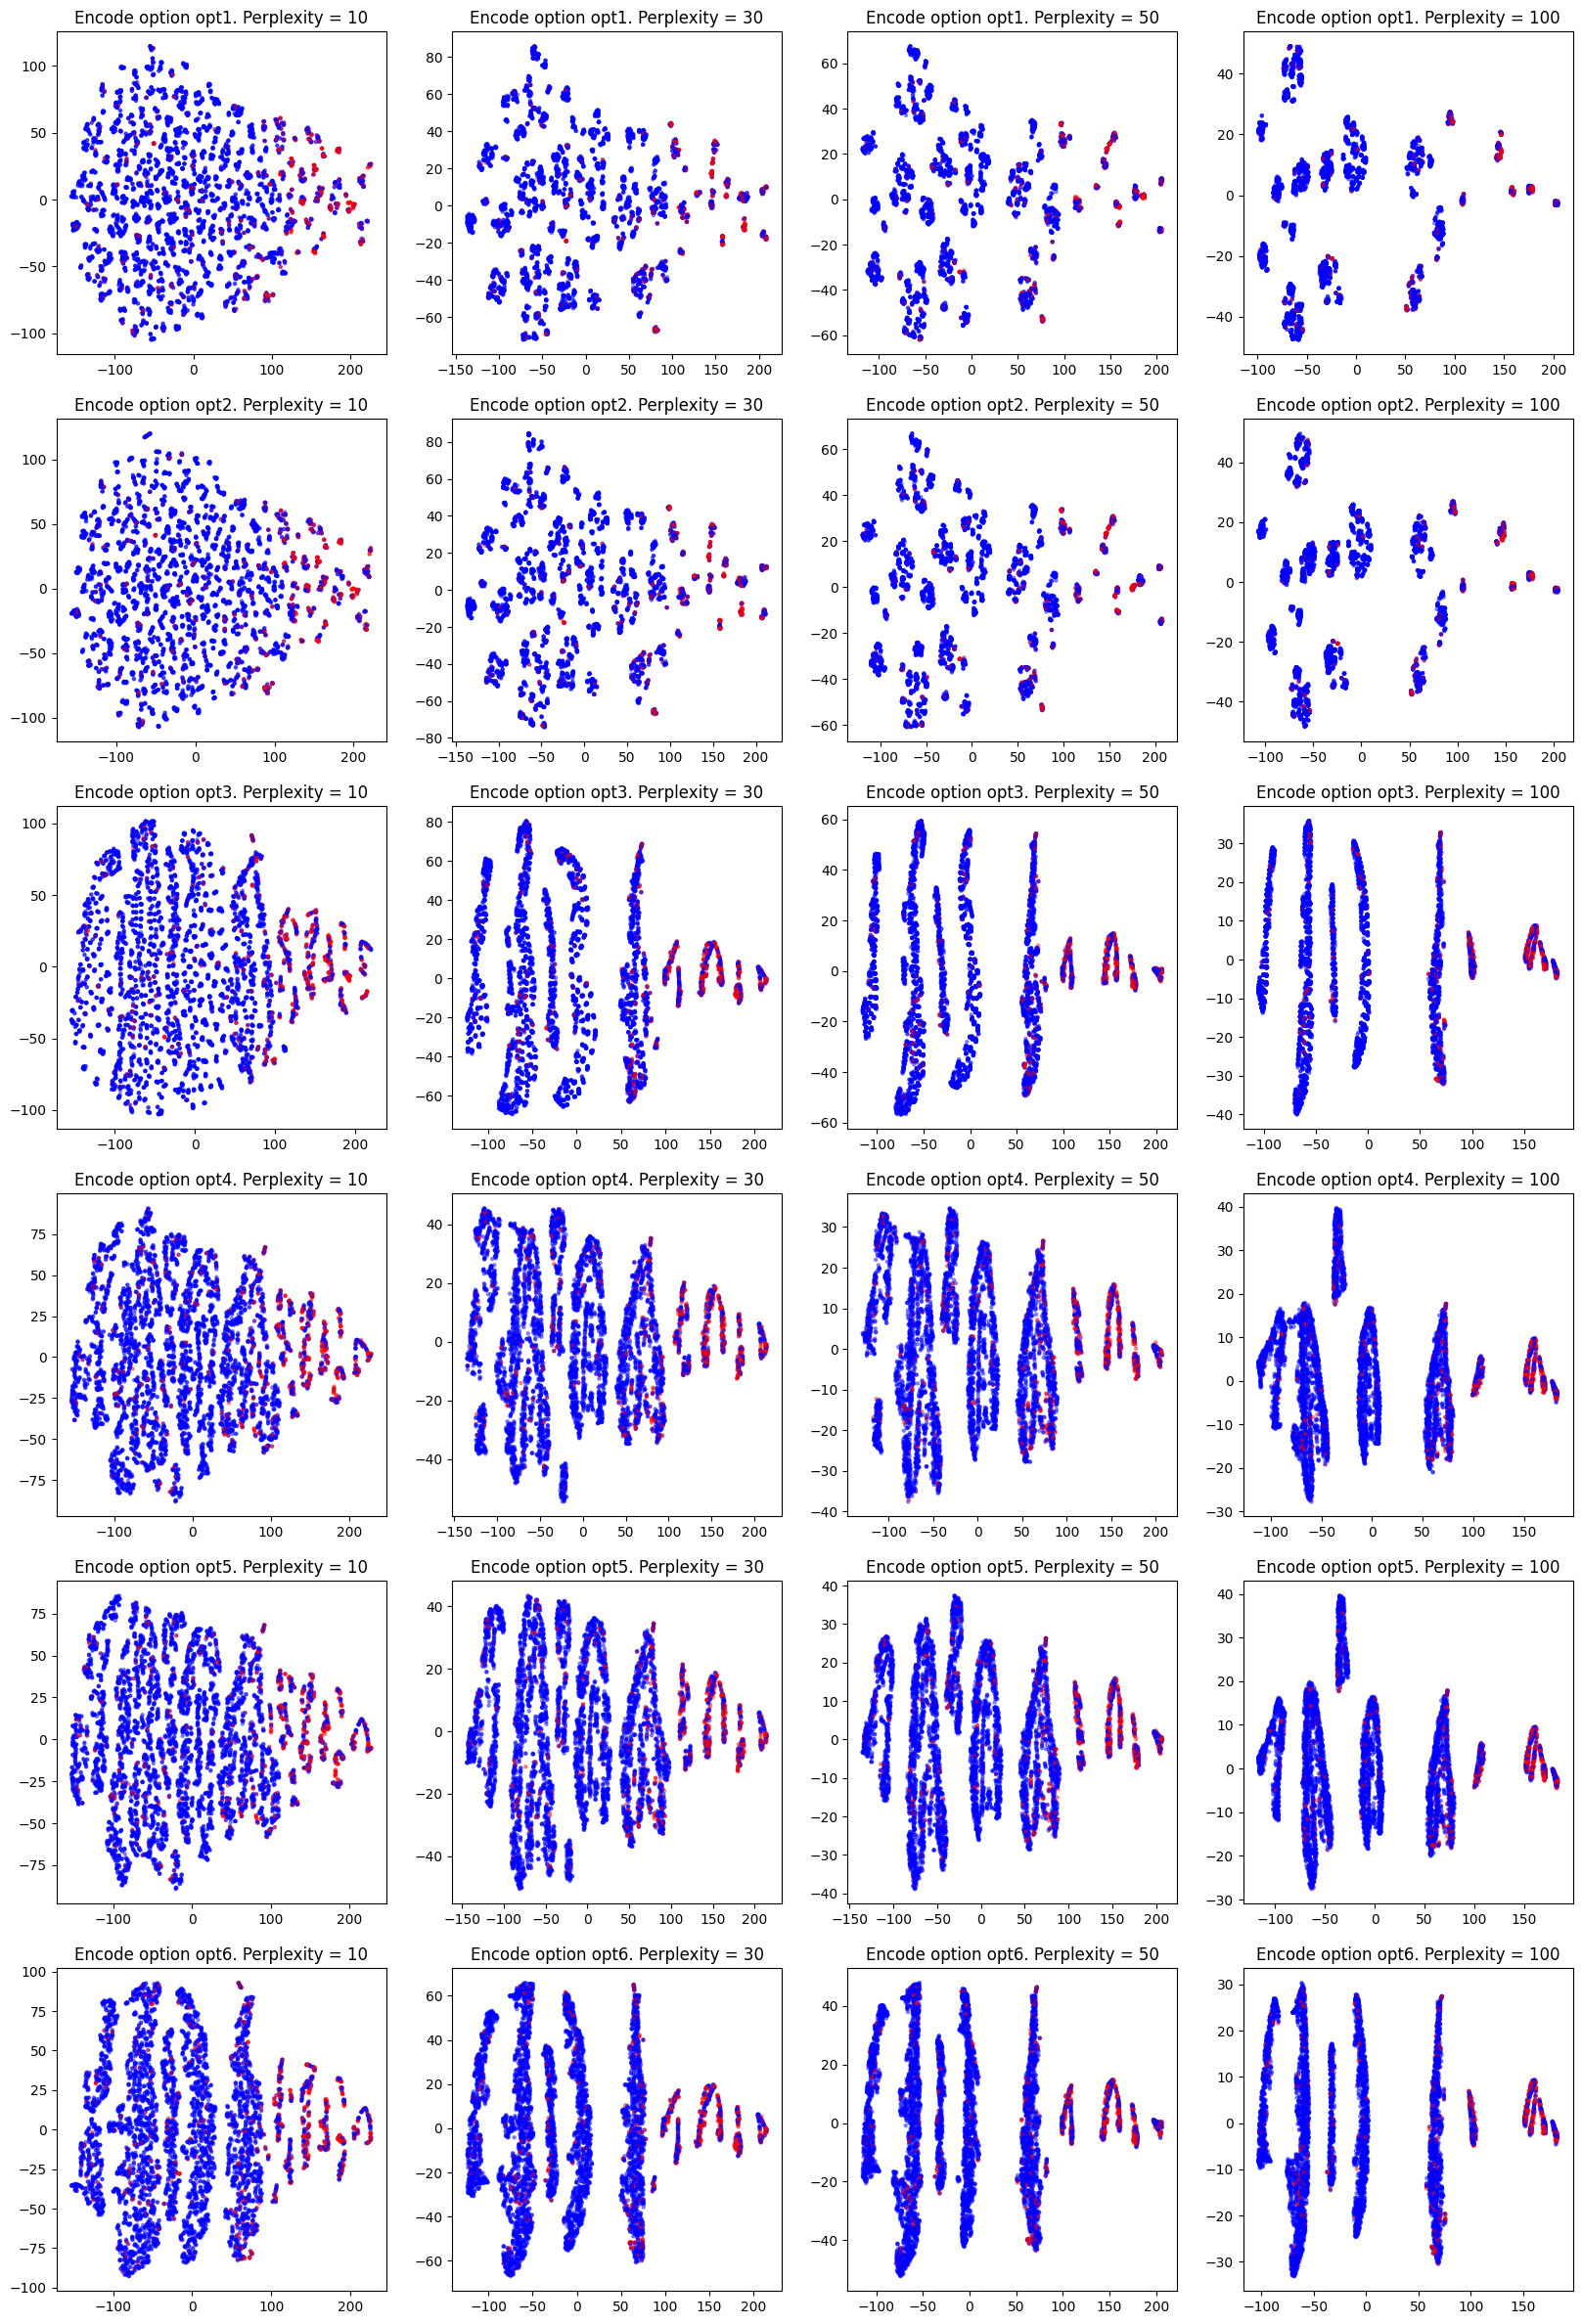

In [34]:
plot_options = ['opt1', 'opt2', 'opt3', 'opt4', 'opt5', 'opt6']
subplot_size = (5, 5) # (width, height)

plots_cols = len(pps)
plots_rows = len(plot_options)
fig, axs = plt.subplots(plots_rows, plots_cols, figsize=(subplot_size[0]*plots_cols, subplot_size[1]*plots_rows))

for i, opt in enumerate(plot_options):
    for j, pp in enumerate(pps):
        tsne_res = tsnes_df[(tsnes_df['preproc_opt'] == opt) & (tsnes_df['perplexity'] == pp)]
        if len(tsne_res) > 0:
            axs[i, j].scatter(tsne_res['tsne_x'], tsne_res['tsne_y'], c=tsne_res['target'], s=5, cmap='bwr', alpha=0.4)
            axs[i, j].set_title(f'Encode option {opt}. Perplexity = {pp}');

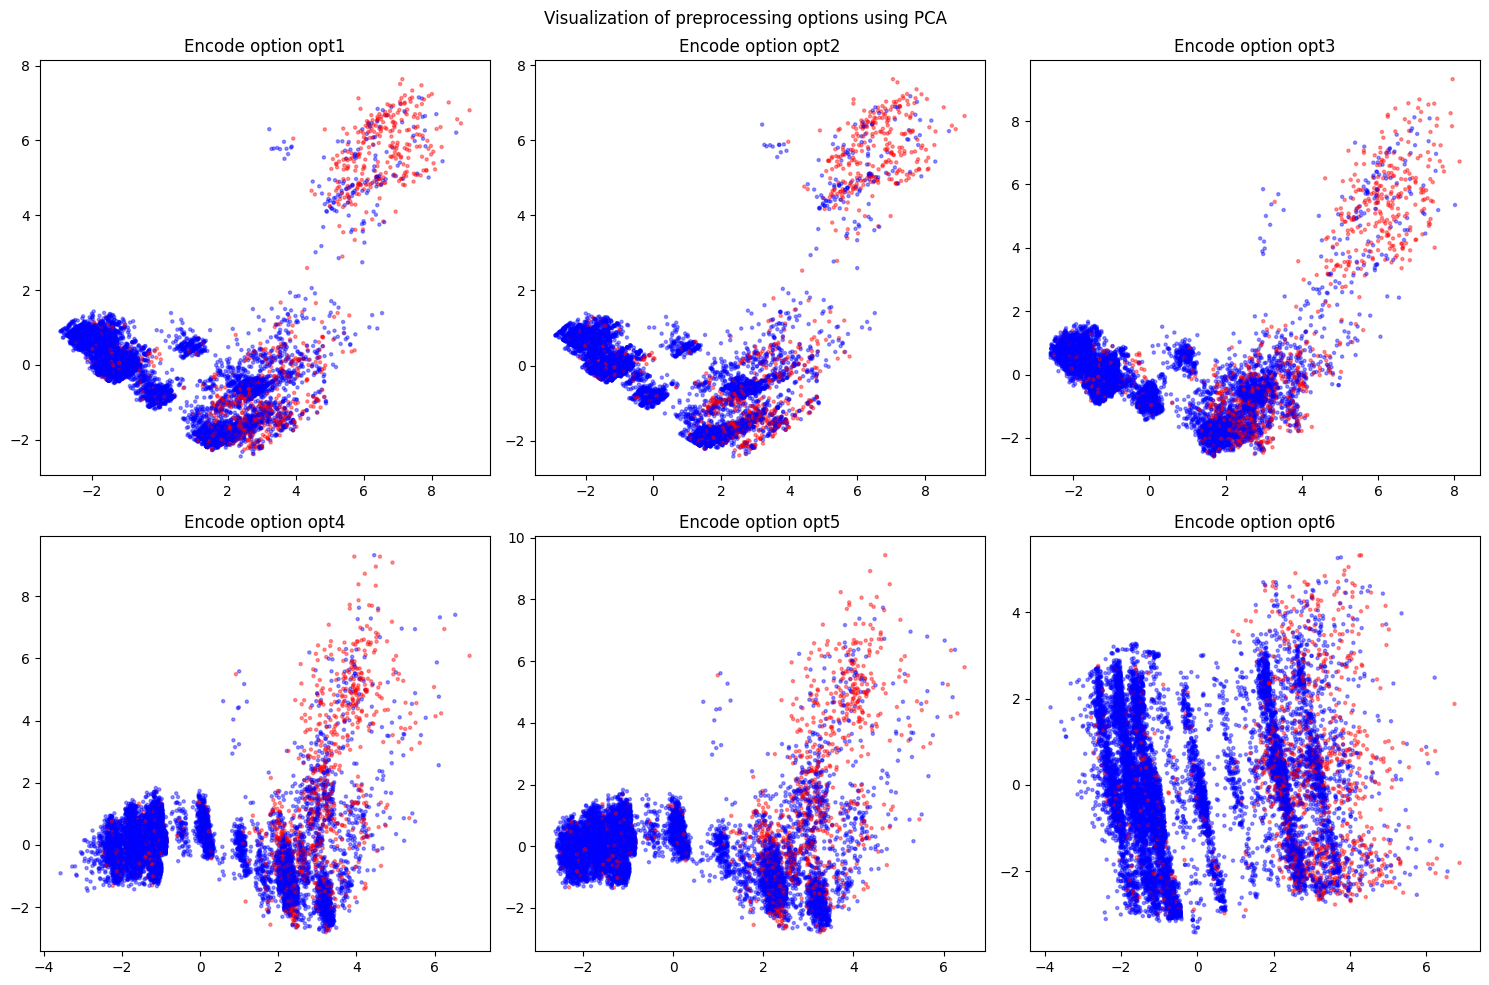

In [41]:
scaler = StandardScaler()
pca = PCA(n_components=2)

plots_cols = 3
plots_rows = int(len(plot_options) / plots_cols)
fig, axs = plt.subplots(plots_rows, plots_cols, figsize=(subplot_size[0]*plots_cols, subplot_size[1]*plots_rows))
fig.suptitle('Visualization of preprocessing options using PCA')
for opt, ax in zip(plot_options, axs.flatten()):
    df_viz = pd.read_csv(f'datasets/processed/bank-test-encoded-{opt}.csv', comment='#')
    X = df_viz.drop(columns='y')
    y = df_viz['y']
    X_scaled = scaler.fit_transform(X)
    X_pca = pca.fit_transform(X_scaled)

    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=5, cmap='bwr', alpha=0.4)
    ax.set_title(f'Encode option {opt}')
fig.tight_layout();